In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RepeatedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
from sklearn.model_selection import cross_validate
from sklearn.metrics.cluster import contingency_matrix
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import scipy.stats as st
from sklearn.inspection import permutation_importance

import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from itertools import chain, combinations
import networkx as nx
from collections import Counter
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import os

https://numba.pydata.org/

In [48]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)
preprocessor = ColumnTransformer(transformers=[
    ('impute', 'passthrough', selector(dtype_include='float64')),
    ('cat', categorical_transformer, selector(dtype_include="object"))
])

In [24]:
powerset = lambda s: [list(x)
                      for x in list(chain.from_iterable(combinations(s, r) 
                                                        for r in range(len(s)+1)))[1::]]

In [25]:
def get_colex_lang(language, dataframe, conc=None):
    if not conc:
        conc = dataframe[dataframe['Name_y'] == language][
            'Concepticon_Gloss'].unique()
    conc_matrix = pd.DataFrame(np.zeros((len(conc), len(conc))), columns=conc,
                               index=conc)
    lang_df = dataframe[(dataframe['Concepticon_Gloss'].isin(conc)) & (
                dataframe['Name_y'] == language)]
    d = dict()
    for i, values in lang_df[['Form', 'Concepticon_Gloss']].iterrows():
        if values['Form'] not in d.keys():
            d[values['Form']] = [values['Concepticon_Gloss']]
        else:
            d[values['Form']].append(values['Concepticon_Gloss'])
    colex_values = []
    for i, j in d.items():
        if len(j) == 2:
            conc_matrix.at[[j[0]], [j[1]]] = 1
            conc_matrix.at[[j[1]], [j[0]]] = 1
            colex_values += [j]
        elif len(j) > 2:
            for comb in [_ for _ in combinations(j, 2)]:
                conc_matrix.at[[comb[0]], [comb[1]]] = 1
                conc_matrix.at[[comb[1]], [comb[0]]] = 1
                colex_values += [comb]
    colex_values_r = []
    colex_values_field = []
    for pair in colex_values:
        colex_values_r.append(pair[::-1])
    return conc_matrix.values, colex_values

### 1. Get data

In [26]:
forms = pd.read_csv(
    '/Users/alexey1/Documents/GitHub/'
    'lexibank-northeuralex-a189844/cldf/forms.csv')
params = pd.read_csv(
    '/Users/alexey1/Documents/GitHub/'
    'lexibank-northeuralex-a189844/cldf/parameters.csv')
languages = pd.read_csv(
    '/Users/alexey1/Documents/GitHub/'
    'lexibank-northeuralex-a189844/cldf/languages.csv')
complete = pd.merge(left=forms.set_index('Parameter_ID'),
                    right=params.set_index('ID'),
                    left_index=True, right_index=True)
complete_nel = pd.merge(left=complete.set_index('Language_ID'),
                        right=languages.set_index('ID'), left_index=True,
                        right_index=True)
complete_nel = complete_nel.dropna(subset=['Latitude', 'Longitude'])
complete_nel = complete_nel.dropna(subset=['Concepticon_Gloss'])
complete_nel = complete_nel[
    ~complete_nel.Name_y.isin(['Latin', 'Standard Arabic'])]
complete_nel.head(4)
len(complete_nel['Name_y'].unique())

105

### 2. Make the dataset

Counting the colexifications and making the colexification repertoire dictionary:

In [4]:
all_colex_langs = []
all_colex = []

for lang in complete_nel.Name_y.unique():
    all_colex += ['{} + {}'.format(i[0], i[1]) 
                     for i in get_colex_lang(lang,
                                             complete_nel)[1]]
    all_colex_langs.append((lang, ['{} + {}'.format(i[0], i[1]) 
                                   for i in get_colex_lang(lang, complete_nel)[1]]))
c_colex = Counter(all_colex)

In [5]:
colex_df = pd.DataFrame(columns=list(c_colex), index=complete_nel.Name_y.unique())
colex_df = colex_df.fillna(0)

for lang in all_colex_langs:
    for colexification in lang[1]:
        colex_df[colexification][lang[0]] = 1

Making the neighbor graph:

In [6]:
distance_m = pd.read_csv('new_km_dist.csv', index_col='Unnamed: 0')
distance_m = distance_m.mask(distance_m <= 1000, 1)
distance_m = distance_m.mask(distance_m > 1000, 0)
G = nx.from_pandas_adjacency(distance_m)
label_mapping = {idx: val for idx, val in enumerate(distance_m.columns)}
G = nx.relabel_nodes(G, label_mapping)

In [7]:
len(nx.shortest_path(G, source='Russian', target='Veps'))

2

In [8]:
inital_dataset = pd.read_csv('new_results_updated_plus_fam.csv')
inital_dataset.head(3)

,Unnamed: 0,Unnamed: 0.1,Language 1,Language 2,Pair,N_sh_colex,N_sh_concepts,Distance,Same_family,Same_genus,WMCD,Population_difference,Sum_of_n_colex,Jackard,Population_difference_log,Family_1,Family_2
0,0,0,Abkhaz,Adyghe,Abkhaz + Adyghe,23,902,199.830288,yes,no,0.061816,385790.0,267,0.094262,12.863048,Abkhaz-Adyge,Abkhaz-Adyge
1,1,1,Abkhaz,Hokkaido Ainu,Abkhaz + Hokkaido Ainu,9,849,7612.530408,no,no,0.025323,190108.0,258,0.036145,12.155348,Abkhaz-Adyge,Ainu
2,2,2,Abkhaz,Aleut,Abkhaz + Aleut,15,890,8899.674611,no,no,0.043326,189960.0,244,0.065502,12.154569,Abkhaz-Adyge,Eskimo-Aleut


In [9]:
def shortest_path(a, b):
    try:
        return len(nx.shortest_path(G, source=a, target=b))
    except:
        return 0

In [10]:
inital_dataset['graph_distance'] = inital_dataset.apply(lambda x: 
                                                        shortest_path(x['Language 1'],
                                                                      x['Language 2']),
                                                        axis=1)

<AxesSubplot:xlabel='graph_distance', ylabel='WMCD'>

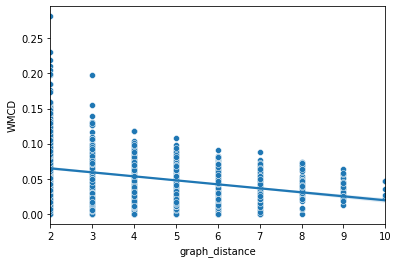

In [11]:
sns.scatterplot(data=inital_dataset[inital_dataset['graph_distance'] > 0], x='graph_distance', y='WMCD')
sns.regplot(data=inital_dataset[inital_dataset['graph_distance'] > 0], x='graph_distance', y='WMCD', scatter=False)

In [12]:
inital_dataset.to_csv('new_results_updated_plus_fam_dist.csv')

Define the NPM metric function:

In [13]:
def NPM(lang, feature):
    res = []
    for lang_ in colex_df.index[colex_df[feature] == 1].tolist():
        try:
            res.append(1/2**len(nx.shortest_path(G, source=lang, target=lang_)))
        except:
            pass
    return sum(res)

Building the inventory dataset: 

In [309]:
with tqdm(total=10) as pbar:
    for n in range(1, 11):
        n = n*100
        if os.path.exists('NPM_datasets/NPM_distribution_{}.csv'.format(n)):
            pass
        else:
#         if n == 1000:
#             # from 1000 to maximum values with at least 2 occurences:
#             n = 1098
            npm = []
            f = []
            sf = []
            feature = []
            lang = []
            prob = []
            present = []

            # 1098 

            for colex in [_[0] for _ in c_colex.most_common(n)]:
                lgs = colex_df.index[colex_df[colex] == 1].tolist()
                for l in colex_df.index.tolist():
                    npm.append(NPM(l, colex))
                    f.append(complete_nel[complete_nel['Name_y'] == l].Family.unique()[0])
                    sf.append(complete_nel[complete_nel['Name_y'] == l].Subfamily.unique()[0])
                    feature.append(colex)
                    lang.append(l)
                    prob.append(c_colex.get(colex)/105)
                    if l in lgs:
                        present.append(1)
                    else:
                        present.append(0)

            results_npm = pd.DataFrame({'Feature': feature, 
                                        'Language': lang, 
                                        'NPM': npm, 
                                        'Family': f, 
                                        'Subfamily': sf,
                                        'Prob': prob, 'Present': present})

            results_npm.to_csv('NPM_datasets/NPM_distribution_{}.csv'.format(n))
            pbar.update(1)

<ipython-input-309-1ac71442c60d>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=10) as pbar:


Rank vs. average NPM value for each language

In [30]:
results_npm = pd.read_csv('NPM_datasets/NPM_distribution_100.csv', index_col = 0)
x = 100

(-10.0, 110.0)

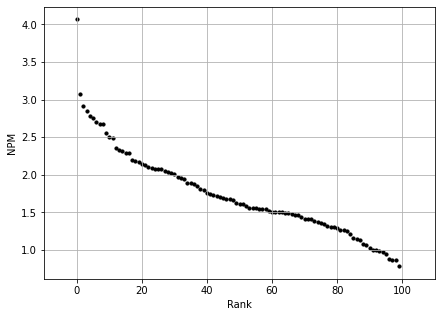

In [31]:
combined = results_npm.groupby('Feature').mean().reset_index()  
combined = combined.sort_values(by='NPM', ascending=False).reset_index().drop(['index'], axis=1)
combined['Log_NPM'] = np.log(combined['NPM'])

plt.figure(figsize=(7, 5))
plt.grid()
plt.scatter([_ for _ in range(x)], combined['NPM'], color='black', alpha=1, s=10)
plt.xlabel('Rank')
plt.ylabel('NPM')
plt.xlim(-10, x+10)

Probability vs. average NPM value for each language

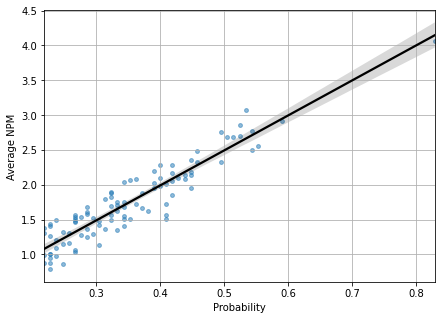

In [32]:
plt.figure(figsize=(7, 5))
plt.scatter(combined['Prob'], combined['NPM'], alpha=0.5, s=15)
sns.regplot(data=combined, x='Prob', y='NPM', scatter=False, color='black')
plt.ylabel('Average NPM')
plt.xlabel('Probability')
plt.grid()

Probability of occurence vs. NPM

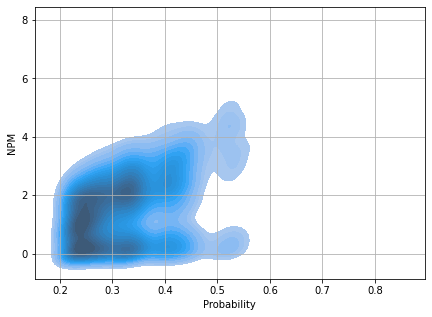

In [45]:
plt.figure(figsize=(7, 5))
sns.kdeplot(x=results_npm['Prob'], y=results_npm['NPM'], fill=True, thresh=0.1, levels=20)
# plt.scatter(results_npm['Prob'], results_npm['NPM'], s=1, color='red', alpha=0.1)
plt.ylabel('NPM')
plt.xlabel('Probability')
plt.grid()

### 3. Model training

In [310]:
def mc_nemar_test(true_values, model1_pred, model2_pred):
    results = pd.DataFrame({'True': true_values, 'Clf_1': model1_pred, 'Clf_2': model2_pred})
    results.loc[results['True'] == results.Clf_1, 'Clf_1_correct'] = 1
    results.loc[results['True'] != results.Clf_1, 'Clf_1_correct'] = 0
    results.loc[results['True'] == results.Clf_2, 'Clf_2_correct'] = 1
    results.loc[results['True'] != results.Clf_2, 'Clf_2_correct'] = 0
    return mcnemar(contingency_matrix(results['Clf_2_correct'],
                                      results['Clf_1_correct']),
                   correction=True)

In [312]:
X = results_npm.drop(['Present', 'Feature', 'Language'], axis=1)
y = results_npm['Present']

In [314]:
X.columns

Index(['NPM', 'Family', 'Subfamily', 'Prob'], dtype='object')

In [315]:
X.shape

(105000, 4)

In [127]:
results = {}
scores = []

for subset in powerset(X.columns):
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingClassifier())])
    scores.append(cross_validate(clf, 
                                 X[subset], y, 
                   scoring=['roc_auc', 
                            'recall',
                            'f1_weighted'], cv=StratifiedKFold(n_splits=10)))
    X_train, X_test, y_train, y_test = train_test_split(X[subset], y, test_size=0.33, stratify=y)
    clf.fit(X_train, y_train)
    results['+'.join(subset)] = [y_test.to_numpy(), clf.predict(X_test), recall_score(y_test, clf.predict(X_test))]

In [128]:
print(pd.DataFrame({'Dataset': ['+'.join(_) for _ in powerset(X.columns)], 
              'roc-auc': ['{} ({})'.format(round(np.mean(_.get('test_roc_auc')), 3), 
                                           round(np.std(_.get('test_roc_auc')), 3)) for _ in scores],
              'recall': ['{} ({})'.format(round(np.mean(_.get('test_recall')), 3), 
                                           round(np.std(_.get('test_recall')), 3)) for _ in scores]})\
.sort_values(by='recall', ascending=False).reset_index().drop(['index'], axis=1).to_latex(index=False))

\begin{tabular}{lll}
\toprule
                   Dataset &        roc-auc &         recall \\
\midrule
      NPM+Family+Subfamily &   0.924 (0.03) &   0.61 (0.233) \\
             NPM+Subfamily &  0.922 (0.031) &  0.596 (0.225) \\
                NPM+Family &  0.915 (0.026) &  0.569 (0.213) \\
                       NPM &  0.905 (0.029) &  0.526 (0.209) \\
 NPM+Family+Subfamily+Prob &   0.57 (0.187) &  0.223 (0.265) \\
        NPM+Subfamily+Prob &  0.579 (0.179) &  0.222 (0.268) \\
           NPM+Family+Prob &  0.527 (0.206) &  0.216 (0.271) \\
                  NPM+Prob &  0.469 (0.234) &  0.162 (0.282) \\
     Family+Subfamily+Prob &   0.136 (0.26) &  0.105 (0.299) \\
               Family+Prob &  0.134 (0.259) &  0.104 (0.299) \\
            Subfamily+Prob &   0.14 (0.267) &  0.102 (0.299) \\
                      Prob &  0.118 (0.232) &      0.1 (0.3) \\
                    Family &  0.604 (0.018) &      0.0 (0.0) \\
                 Subfamily &   0.62 (0.015) &      0.0 (0.0) \\
 

In [129]:
names = ['+'.join(_) for _ in powerset(X.columns)]

mc_newmar_m = pd.DataFrame(np.zeros((len(names), len(names))), columns=names,
                               index=names)

In [131]:
for pair in combinations(powerset(X.columns), r=2):
    t_result = mc_nemar_test(results.get('+'.join(pair[0]))[0], 
                             results.get('+'.join(pair[0]))[1],
                             results.get('+'.join(pair[1]))[1])
    mc_newmar_m.at[['+'.join(pair[1])], ['+'.join(pair[0])]] = t_result.pvalue
#     print('Pair: {}, score model 1: {}, score model 2: {}, mc newmar p: {}'.format(pair, 
#                                                                                    results.get('+'.join(pair[0]))[2],
#                                                                                    results.get('+'.join(pair[1]))[2], 
#                                                                                    t_result))

In [138]:
0.05/len(list(combinations(powerset(X.columns), r=2)))

0.0004761904761904762

In [139]:
len(powerset(X.columns))

15

In [140]:
m = mc_newmar_m.mask(mc_newmar_m.values <= 0.05/105).fillna(0)
m = m.mask(m.values > 0.05/105).fillna(1)

In [141]:
m

,NPM,Family,Subfamily,Prob,NPM+Family,NPM+Subfamily,NPM+Prob,Family+Subfamily,Family+Prob,Subfamily+Prob,NPM+Family+Subfamily,NPM+Family+Prob,NPM+Subfamily+Prob,Family+Subfamily+Prob,NPM+Family+Subfamily+Prob
NPM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Family,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Subfamily,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Prob,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NPM+Family,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NPM+Subfamily,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NPM+Prob,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Family+Subfamily,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Family+Prob,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Subfamily+Prob,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [142]:
0.05/105

0.0004761904761904762

<Figure size 576x576 with 0 Axes>

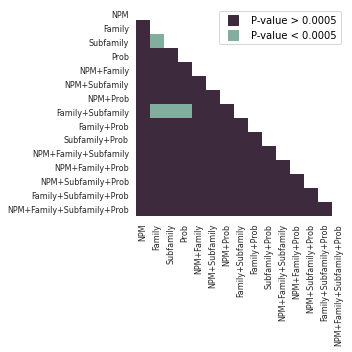

In [143]:
plt.figure(figsize=(8, 8))
mask = np.zeros_like(m)
mask[np.triu_indices_from(m)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(m, mask=mask, vmax=.3, square=True, cbar=False, cmap=['#3D2B3D', '#81AE9D'])

custom_lines = [Line2D([0], [0], color='#3D2B3D', lw=0, marker='s', markersize=10),
                Line2D([0], [0], color="#81AE9D", lw=0, marker='s', markersize=10)]
plt.legend(custom_lines, ['P-value > 0.0005', 'P-value < 0.0005'])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
    
plt.savefig('P_values_NPM.pdf', dpi=300, bbox_inches = "tight")

#### 3.3. Performance under different number of concepts

In [59]:
sc = []

for n in range(1, 11):
    n = n*100
    dataset = pd.read_csv('NPM_datasets/NPM_distribution_{}.csv'.format(n), index_col=0)
    y = dataset['Present']
    X = dataset.drop(['Present', 'Feature', 'Language'], axis=1)
    results = {}
    scores = []
    for subset in powerset(X.columns):
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', GradientBoostingClassifier())])
        scores.append(cross_validate(clf, 
                                     X[subset], y, 
                       scoring=['precision', 
                                'recall', 'f1'], cv=RepeatedKFold(n_splits=5, n_repeats=10), 
                                     n_jobs=5))
#         StratifiedKFold(n_splits=5)
    sc.append([n, scores])
    print('% Dataset with {} colexifications for each lg'.format(n))
    print(pd.DataFrame({'Dataset': ['+'.join(_) for _ in powerset(X.columns)], 
              'Precision': ['{} ({})'.format(round(np.mean(_.get('test_precision')), 3), 
                                           round(np.std(_.get('test_precision')), 3)) for _ in scores],
              'Recall': ['{} ({})'.format(round(np.mean(_.get('test_recall')), 3), 
                                           round(np.std(_.get('test_recall')), 3)) for _ in scores], 
              'F1': ['{} ({})'.format(round(np.mean(_.get('test_f1')), 3), 
                                           round(np.std(_.get('test_f1')), 3)) for _ in scores]})\
          .sort_values(by='Recall', ascending=False).reset_index().drop(['index'], axis=1).to_latex(index=False))

% Dataset with 100 colexifications for each lg
\begin{tabular}{llll}
\toprule
                   Dataset &      Precision &         Recall &             F1 \\
\midrule
      NPM+Family+Subfamily &  0.742 (0.017) &  0.672 (0.028) &  0.705 (0.015) \\
 NPM+Family+Subfamily+Prob &  0.755 (0.019) &  0.669 (0.019) &  0.709 (0.011) \\
             NPM+Subfamily &  0.742 (0.021) &   0.665 (0.03) &    0.7 (0.014) \\
        NPM+Subfamily+Prob &  0.758 (0.018) &   0.66 (0.025) &  0.705 (0.014) \\
           NPM+Family+Prob &  0.742 (0.017) &   0.627 (0.02) &  0.679 (0.011) \\
                NPM+Family &  0.741 (0.027) &  0.612 (0.022) &   0.67 (0.013) \\
                       NPM &  0.715 (0.014) &  0.603 (0.016) &   0.654 (0.01) \\
                  NPM+Prob &   0.733 (0.02) &  0.593 (0.023) &  0.656 (0.016) \\
     Family+Subfamily+Prob &  0.604 (0.034) &  0.193 (0.016) &  0.292 (0.018) \\
               Family+Prob &  0.593 (0.032) &  0.191 (0.021) &  0.288 (0.023) \\
            Subfamily+

% Dataset with 700 colexifications for each lg
\begin{tabular}{llll}
\toprule
                   Dataset &      Precision &         Recall &             F1 \\
\midrule
 NPM+Family+Subfamily+Prob &  0.762 (0.015) &   0.496 (0.02) &  0.601 (0.015) \\
      NPM+Family+Subfamily &  0.722 (0.013) &  0.492 (0.014) &  0.585 (0.012) \\
           NPM+Family+Prob &  0.755 (0.014) &  0.487 (0.016) &  0.592 (0.012) \\
             NPM+Subfamily &  0.709 (0.014) &  0.487 (0.011) &   0.577 (0.01) \\
        NPM+Subfamily+Prob &  0.756 (0.017) &  0.471 (0.017) &   0.58 (0.013) \\
                  NPM+Prob &  0.707 (0.016) &  0.438 (0.011) &  0.541 (0.009) \\
                NPM+Family &  0.716 (0.015) &  0.428 (0.013) &  0.536 (0.011) \\
                       NPM &  0.613 (0.014) &  0.359 (0.011) &   0.453 (0.01) \\
     Family+Subfamily+Prob &   0.602 (0.04) &  0.089 (0.009) &  0.155 (0.014) \\
               Family+Prob &  0.596 (0.036) &   0.087 (0.01) &  0.152 (0.015) \\
            Subfamily+

In [60]:
recall = []
n_of_colex = []
model = []

mods = ['+'.join(_) for _ in powerset(X.columns)]

for element in sc:
    res = []
    print(element[0])
    for i in range(len(element[1])):
        model += [mods[i]]*50
        recall += list(element[1][i].get('test_recall'))
        n_of_colex += [element[0]]*50

100
200
300
400
500
600
700
800
900
1000


In [61]:
['+'.join(_) for _ in powerset(X.columns)]

['NPM',
 'Family',
 'Subfamily',
 'Prob',
 'NPM+Family',
 'NPM+Subfamily',
 'NPM+Prob',
 'Family+Subfamily',
 'Family+Prob',
 'Subfamily+Prob',
 'NPM+Family+Subfamily',
 'NPM+Family+Prob',
 'NPM+Subfamily+Prob',
 'Family+Subfamily+Prob',
 'NPM+Family+Subfamily+Prob']

In [62]:
pd.DataFrame({'N of colex': n_of_colex, 'Recall': recall, 'Model': model})\
.to_csv('NPM_diff_model_res.csv')

#### 3.4. Best model examination

In [259]:
results_npm = pd.read_csv('NPM_datasets/NPM_distribution_100.csv', index_col=0)

# 
# X = results_npm.drop(['Present', 'Feature'], axis=1)
X = results_npm.drop(['Present', 'Feature', 'Language'], axis=1)
y = results_npm['Present']

In [254]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [255]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', GradientBoostingClassifier())])
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('impute', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff8e1c07910>),
                                                 ('cat',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown=...
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
 

In [256]:
# X_test['Predicted_probability'] = clf.predict_proba(X_test)[:, 1]

In [257]:
# X_test['NPM_round'] = round(X_test['NPM'], 1)
# pred = X_test.groupby('NPM_round').mean().reset_index()
# results_npm['NPM_round'] = round(results_npm['NPM'], 1)
# true = results_npm.groupby('NPM_round').mean().reset_index()
# plt.figure(figsize=(7, 5))
# plt.scatter(pred['NPM'], pred['Predicted_probability'], alpha=1, label='Predicted (test set)')
# plt.scatter(true['NPM_round'], true['Present'], alpha=1, label='True labels')
# plt.legend()
# plt.xlabel('NPM (round to 1 digit)')
# plt.ylabel('Probability of presence')
# plt.ylim(0, 1)

In [258]:
results_fam = []

for _ in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X[['NPM', 'Family','Subfamily','Prob']], 
                                                        y, test_size=0.33, 
                                                        stratify=y)
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', GradientBoostingClassifier())])
    clf.fit(X_train, y_train)
    X_test['Predicted'] = clf.predict(X_test)
    X_test['True'] = y_test
    X_test = X_test[X_test['True'] == 1]
    X_test.loc[X_test['True'] == X_test['Predicted'], 'Correct'.format(_)] = 1
    X_test.loc[X_test['True'] !=  X_test['Predicted'], 'Correct'.format(_)] = 0
    final = X_test[['Family', 'Correct']].groupby('Family').mean()
    final['Run'] = 'Run {}'.format(_)
    results_fam.append(final)
results_fam = pd.concat(results_fam, axis=0).reset_index()
results_fam['n of observations'] = results_fam['Family']\
.map(dict([(_[0], _[1]/x) 
           for _ in 
           Counter(results_npm['Family']).most_common(40)]))
results_fam.to_csv('percent_correct_NPM_family.csv')

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [166]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', GradientBoostingClassifier())])
clf.fit(X_train, y_train)
result = permutation_importance(clf, X_train, y_train, n_repeats=200, n_jobs=2, scoring='recall')
sorted_idx = result.importances_mean.argsort()
results_perm = pd.DataFrame(result.importances[sorted_idx].T, columns=np.array(X.columns)[sorted_idx])
results_perm = results_perm.unstack().reset_index().drop(['level_1'], axis=1)
results_perm.columns = ['Variable', 'Importance']
results_perm['Set'] = 'Train'
results_perm_t = results_perm

In [167]:
result = permutation_importance(clf, X_test, y_test, n_repeats=200, n_jobs=2, scoring='recall')
sorted_idx = result.importances_mean.argsort()
results_perm = pd.DataFrame(result.importances[sorted_idx].T, columns=np.array(X.columns)[sorted_idx])
results_perm = results_perm.unstack().reset_index().drop(['level_1'], axis=1)
results_perm.columns = ['Variable', 'Importance']
results_perm['Set'] = 'Test'
results_perm.head(10)
results_perm_tr = results_perm

In [168]:
pd.concat([results_perm_t, results_perm_tr], axis=0).to_csv('sim_res_gbr_NPM.csv')

Correct permutation importance:

In [261]:
def get_perm_res(X=results_npm[['NPM', 'Family','Subfamily','Prob']]):
    results_imp = []

    for _ in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, test_size=0.33, 
                                                            stratify=y)
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier())])
        clf.fit(X_train, y_train)
        result = permutation_importance(clf, X_test, y_test, n_repeats=50, n_jobs=2, scoring='recall')
        sorted_idx = result.importances_mean.argsort()
        results_perm = pd.DataFrame(result.importances[sorted_idx].T, columns=np.array(X.columns)[sorted_idx])
        results_perm = results_perm.unstack().reset_index().drop(['level_1'], axis=1)
        results_perm.columns = ['Variable', 'Importance']
        results_imp.append(results_perm)

    results = pd.concat(results_imp, axis=0).groupby('Variable')\
    .agg(['mean', 'std']).reset_index()
    results.columns = results.columns.droplevel()
    print(results.sort_values(by='mean', ascending=False).to_latex(index=False))

In [246]:
get_perm_res()

\begin{tabular}{lrr}
\toprule
           &      mean &       std \\
\midrule
       NPM &  0.329899 &  0.016609 \\
 Subfamily &  0.047593 &  0.013163 \\
    Family &  0.000686 &  0.010122 \\
      Prob & -0.004599 &  0.009084 \\
\bottomrule
\end{tabular}



In [244]:
get_perm_res(results_npm[['NPM', 'Family','Subfamily','Prob', 'Language']])

\begin{tabular}{lrr}
\toprule
           &      mean &       std \\
\midrule
       NPM &  0.320527 &  0.019000 \\
 Subfamily &  0.039515 &  0.012052 \\
  Language &  0.009574 &  0.008192 \\
    Family &  0.007977 &  0.010494 \\
      Prob & -0.001553 &  0.008958 \\
\bottomrule
\end{tabular}

